In [1]:
# The cells in this notebook run each step in the HydroFlow workflow
# This workflow was developed to function from within the designated SnowModel
# folder for each domain.

# Import all of the python packages used in this workflow.
import scipy
import numpy as np
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from datetime import date, datetime
from datetime import timedelta  
import json
from xgrads import open_CtlDataset
import os
import glob
import requests
import matplotlib.pyplot as plt


# Choose a domain
domain = 'BEAU'

# huc label
huc = 'HUC4 1906'

# Path to the SnowModel folder
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
#SMpath = '/scratch/Nina/NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'

# path to files
wsd_ctl = SMpath+'/watershed/watershed.ctl'
wsdlistpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/watersheds.csv'

# results path
resultpath = '/nfs/attic/dfh/2020_NPRB/data/results/'+domain+'/'

# results figures path
figpath = '/nfs/attic/dfh/2020_NPRB/data/results/figures/'

#path to coast mask
coastmaskpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/coast_mask.nc'
coast = xr.open_dataset(coastmaskpath)

# open watershed data
wd = open_CtlDataset(wsd_ctl)

# open list of watersheds to include
wsd_list = pd.read_csv(wsdlistpath,index_col=0)
wsdlist=wsd_list.wd.tolist()

# open indexing df
df=pd.read_csv(resultpath+domain+'_coast_cells_ll.csv')

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()
    
# Define nx and ny for this domain to be used later
nx = domains[domain]['ncols']
ny = domains[domain]['nrows']
clsz = domains[domain]['cellsize']
xll = domains[domain]['xll']
yll = domains[domain]['yll']

#future dates
fut = pd.date_range(start ='10-01-2070', end ='09-30-2100', freq ='1D')


# gridded variables

## disc

In [9]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_fut/disc*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Qs = []
anQ = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    q = open_CtlDataset(file)
    # sum slow and fast flow
    qtot = q.fast + q.slow
    # select second year
    qtotslice = qtot.isel(lev=0).sel(time=slice(str(int(file[-13:-9])-80)+'-10-01',str(int(file[-8:-4])-80)+'-09-30'))
    # store water year
    wy.append(str(int(file[-8:-4])-80))
    # mask to HUC4
    qtotslice = qtotslice.where((qtotslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Qs.append(qtotslice.values)
    # Q at coast cells
    qtotmask = qtotslice.where(coast.maskq==1)
    # annual Q
    anQ.append(qtotmask.sum(dim=['time','lat','lon']).values.tolist())
# convert lists to arrays
qclims = np.concatenate(Qs)
qclims = qclims[0:-1,:,:]

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2070-2071.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2071-2072.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2072-2073.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2073-2074.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2074-2075.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2075-2076.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2076-2077.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2077-2078.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2078-2079.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2079-2080.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/disc_2080-2081.ctl
/nfs/attic/dfh/2020_NPRB/domain_

In [25]:
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    disc=(["time","y", "x"],
          qclims,
          {'units':'cubic meters per day',
           'long_name':'Daily discharge',
           'standard_name':'runoff_flux',
           'standard_units':'kg m-2 s-1'}),
),
coords=dict(
    time=fut,
    y=q.lat.values,
    x=q.lon.values,
),)

# add dataset of origin to attribute list
ds['coast_mask']=(('y','x'),coast.maskq.values)  
ds.attrs.update({
    'title':'Freshwater Discharge Across 4-digit HUC 1906 into the Beaufort Sea',
    'summary':'Coastal FWD was modeled using a suite of physically based, spatially distributed weather, energy-balance snow/ice melt, soil water balance, and runoff routing models at a high resolution (1 km horizontal grid; daily time step). Discharge was modeled across the 1906 HUC4 subregion.',
    'keywords':'DISCHARGE/FLOW, ALASKA, BEAUFORT SEA, HUC4 1906',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner',
    'coast_mask':'Values of 1 indicate coastal pixels.'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_disc_wy2071-2100.nc')

In [6]:
ds = xr.open_dataset(resultpath+domain+'_disc_wy2071-2100.nc')
ds

<xarray.Dataset>
Dimensions:      (time: 10957, y: 496, x: 1298)
Coordinates:
  * time         (time) datetime64[ns] 2070-10-01 2070-10-02 ... 2100-09-30
  * y            (y) float32 1.96e+06 1.961e+06 ... 2.454e+06 2.455e+06
  * x            (x) float32 -5.43e+05 -5.42e+05 -5.41e+05 ... 7.53e+05 7.54e+05
Data variables:
    disc         (time, y, x) float32 ...
    coast_mask   (y, x) float64 ...
    spatial_ref  int64 ...
Attributes:
    title:          Freshwater Discharge Across 4-digit HUC 1906 into the Bea...
    summary:        Coastal FWD was modeled using a suite of physically based...
    keywords:       DISCHARGE/FLOW, ALASKA, BEAUFORT SEA, HUC4 1906
    date_created:   Dataset created March 2024
    creator_name:   Christina Marie Aragon
    creator_email:  aragonch@oregonstate.edu
    institution:    Oregon State University
    note:           x y coordinates correspond to lower left corner
    coast_mask:     Values of 1 indicate coastal pixels.

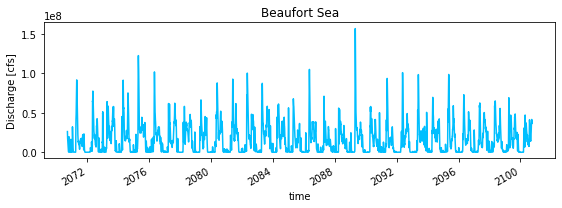

In [27]:
# coastal discharge
coastalQ = ds.disc.sum(dim=['x','y'])
# convert units
coastQft3 = coastalQ*35.3147/(24*60*60)
fig, ax = plt.subplots(1,figsize=[8,3])
coastQft3.plot(c='#00bfff',ax=ax)
ax.set_ylabel('Discharge [cfs]')
plt.title('Beaufort Sea')
plt.tight_layout()
fig.savefig(figpath+domain+'coastalQ_wy2071-2100.png',dpi=300)

In [28]:
# save out annual Q data
dfq = pd.DataFrame({'water_year':wy,'annual_Qcoast_m3':anQ})
dfq.to_csv(resultpath+'temp/'+domain+'_annual_disc_coast_wy2071-2100.csv')

In [7]:
# coastal disc .nc
#empty array to store data
ar = np.empty([len(df),len(ds.time)])

for i in range(len(df)):
    # select disc at each of the coastal pixels
    ar[i,:]=ds.disc.isel(x=df.grid_X[i],y=df.grid_Y[i]).values
    
# coastal grid
# build xarray data array to save out
qcoastclim = xr.DataArray(
    ar,
    dims=['id','time'],
    coords={
        'id':df.cell_id.values,
        'lat': ('id',df.lat.values),
        'lon': ('id',df.lon.values),
        'time':fut,},
    attrs={'units':'cubic meters per day',
           'long_name':'Daily discharge',
           'standard_name':'runoff_flux',
           'standard_units':'kg m-2 s-1'}
)
# convert to dataset
dsc=qcoastclim.to_dataset(name = 'disc_coast') 
# add dataset of origin to attribute list
dsc.attrs.update({
    'title':'Coastal Freshwater Discharge from 4-digit HUC 1906 into the Beaufort Sea',
    'summary':'Coastal FWD was modeled using a suite of physically based, spatially distributed weather, energy-balance snow/ice melt, soil water balance, and runoff routing models at a high resolution (1 km horizontal grid; daily time step). Discharge was modeled across the 1906 HUC4 subregion.',
    'keywords':'DISCHARGE/FLOW, ALASKA, BEAUFORT SEA, HUC4 1906',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'projection':'epsg:4326',
    'note':'lat lon coordinates correspond to lower left corner'
})
# save to .nc file
dsc.to_netcdf(resultpath+domain+'_disc_coast_wy2071-2100.nc')

In [8]:
dsc = xr.open_dataset(resultpath+domain+'_disc_coast_wy2071-2100.nc')
dsc

<xarray.Dataset>
Dimensions:     (id: 1066, time: 10957)
Coordinates:
  * id          (id) int64 0 1 2 3 4 5 6 ... 1059 1060 1061 1062 1063 1064 1065
    lat         (id) float64 ...
    lon         (id) float64 ...
  * time        (time) datetime64[ns] 2070-10-01 2070-10-02 ... 2100-09-30
Data variables:
    disc_coast  (id, time) float64 ...
Attributes:
    title:          Coastal Freshwater Discharge from 4-digit HUC 1906 into t...
    summary:        Coastal FWD was modeled using a suite of physically based...
    keywords:       DISCHARGE/FLOW, ALASKA, BEAUFORT SEA, HUC4 1906
    date_created:   Dataset created March 2024
    creator_name:   Christina Marie Aragon
    creator_email:  aragonch@oregonstate.edu
    institution:    Oregon State University
    projection:     epsg:4326
    note:           lat lon coordinates correspond to lower left corner

## prec

In [ ]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_fut/prec*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
anD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.prec.sel(time=slice(str(int(file[-13:-9])-80)+'-10-01',str(int(file[-8:-4])-80)+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # annual P [cubic m]
    anD.append(maskslice.sum(dim=['time','lat','lon']).values.tolist()*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
dataclims = dataclims[0:-1,:,:]

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2070-2071.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2071-2072.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2072-2073.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2073-2074.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2074-2075.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2075-2076.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2076-2077.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2077-2078.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2078-2079.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2079-2080.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/prec_2080-2081.ctl
/nfs/attic/dfh/2020_NPRB/domain_

In [66]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    prec=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily precipitation',
           'standard_name':'precipitation_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=fut,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Precipitation Across 4-digit HUC 1906',
    'summary':'Precipitation was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (1 km horizontal grid; daily time step). Precipitation was modeled across the 1906 HUC4 subregion.',
    'keywords':'PRECIPITATION, ALASKA, HUC4 1906',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_prec_wy2071-2100.nc')

In [67]:
# save out annual P data
dfdata = pd.DataFrame({'water_year':wy,'annual_prec_m3':anD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_prec_wy2071-2100.csv')

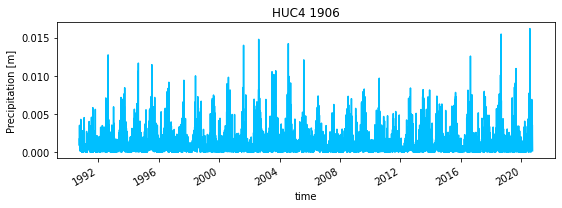

In [69]:
ds = xr.open_dataset(resultpath+domain+'_prec_wy2071-2100.nc')
plotdata = ds.prec.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00bfff',ax=ax)
ax.set_ylabel('Precipitation [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_P_wy2071-2100.png',dpi=300)

## ET

In [15]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_fut/etx*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
anD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.etx.sel(time=slice(str(int(file[-13:-9])-80)+'-10-01',str(int(file[-8:-4])-80)+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # annual P [cubic m]
    anD.append(maskslice.sum(dim=['time','lat','lon']).values.tolist()*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
dataclims = dataclims[0:-1,:,:]

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2070-2071.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2071-2072.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2072-2073.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2073-2074.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2074-2075.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2075-2076.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2076-2077.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2077-2078.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2078-2079.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2079-2080.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/etx_2080-2081.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmo

In [16]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    et=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily evapotranspiration',
           'standard_name':'water_evapotranspiration_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=fut,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Evapotranspiration Across 4-digit HUC 1906',
    'summary':'Evapotranspiration was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (1 km horizontal grid; daily time step). Evapotranspiration was modeled across the 1906 HUC4 subregion.',
    'keywords':'EVAPOTRANSPIRATION, ALASKA, HUC4 1906',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_etx_wy2071-2100.nc')

In [17]:
# save out annual ET data
dfdata = pd.DataFrame({'water_year':wy,'annual_etx_m3':anD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_etx_wy2071-2100.csv')

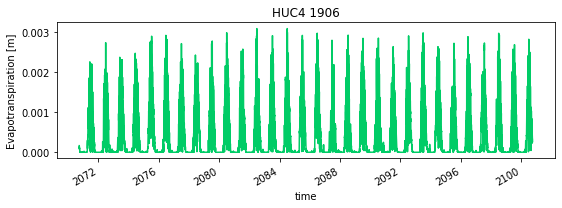

In [18]:
ds = xr.open_dataset(resultpath+domain+'_etx_wy2071-2100.nc')
plotdata = ds.et.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00cc66',ax=ax)
ax.set_ylabel('Evapotranspiration [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_ET_wy2071-2100.png',dpi=300)

## SUB

In [3]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_fut/ssub*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
anD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.ssub.sel(time=slice(str(int(file[-13:-9])-80)+'-10-01',str(int(file[-8:-4])-80)+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # annual P [cubic m]
    anD.append(maskslice.sum(dim=['time','lat','lon']).values.tolist()*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
dataclims = dataclims[0:-1,:,:]

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2070-2071.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2071-2072.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2072-2073.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2073-2074.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2074-2075.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2075-2076.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2076-2077.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2077-2078.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2078-2079.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2079-2080.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/ssub_2080-2081.ctl
/nfs/attic/dfh/2020_NPRB/domain_

In [4]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    sub=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily sublimation',
           'standard_name':'surface_snow_sublimation_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=fut,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Sublimation Across 4-digit HUC 1906',
    'summary':'Sublimation was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (1 km horizontal grid; daily time step). Sublimation was modeled across the 1906 HUC4 subregion.',
    'keywords':'SUBLIMATION, ALASKA, HUC4 1906',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_ssub_wy2071-2100.nc')

In [5]:
# save out annual SUB data
dfdata = pd.DataFrame({'water_year':wy,'annual_ssub_m3':anD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_ssub_wy2071-2100.csv')

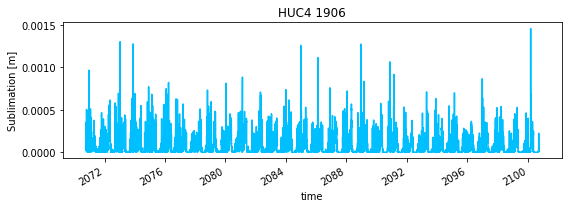

In [6]:
ds = xr.open_dataset(resultpath+domain+'_ssub_wy2071-2100.nc')
plotdata = ds.sub.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00bfff',ax=ax)
ax.set_ylabel('Sublimation [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_SUB_wy2071-2100.png',dpi=300)

## SWE

In [11]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_fut/swed*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
anD = []
endD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.swed.sel(time=slice(str(int(file[-13:-9])-80)+'-10-01',str(int(file[-8:-4])-80)+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # daily swe sum
    swesum = maskslice.sum(dim=['lat','lon'])
    # date of max swe
    mxtime = swesum.time.where(swesum==swesum.max(),drop=True).values
    # annual max swe [m]
    anD.append(maskslice.sel(time = mxtime).sum().values*int(clsz)*int(clsz))
    # swe left on last day
    endD.append(maskslice.isel(time=-1).sum().values*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
dataclims = dataclims[0:-1,:,:]

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2070-2071.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2071-2072.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2072-2073.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2073-2074.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2074-2075.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2075-2076.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2076-2077.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2077-2078.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2078-2079.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2079-2080.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/swed_2080-2081.ctl
/nfs/attic/dfh/2020_NPRB/domain_

In [12]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    swed=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily snow water equivalent',
           'standard_name':'lwe_thickness_of_surface_snow_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=fut,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Snow Water Equivalent Across 4-digit HUC 1906',
    'summary':'Snow Water Equivalent was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (1 km horizontal grid; daily time step). Snow Water Equivalent was modeled across the 1906 HUC4 subregion.',
    'keywords':'SNOW WATER EQUIVALENT, SWE, ALASKA, HUC4 1906',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_swed_wy2071-2100.nc')

In [13]:
# save out annual SWE data
dfdata = pd.DataFrame({'water_year':wy,'annual_max_swed_m3':anD,'endofwy_swed_m3':endD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_swed_wy2071-2100.csv')

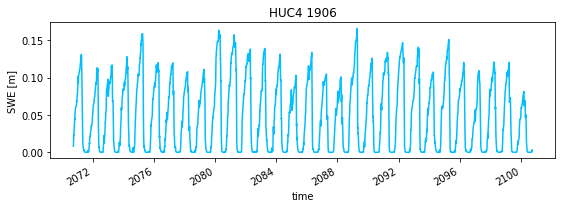

In [14]:
ds = xr.open_dataset(resultpath+domain+'_swed_wy2071-2100.nc')
plotdata = ds.swed.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00bfff',ax=ax)
ax.set_ylabel('SWE [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_SWE_wy2071-2100.png',dpi=300)

## Temp

In [7]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_fut/tair*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
avD = []
mnD = []
mxD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.tair.sel(time=slice(str(int(file[-13:-9])-80)+'-10-01',str(int(file[-8:-4])-80)+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>-9999)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # daily temp across domain
    dailyT = maskslice.mean(dim=['lat','lon'])
    # annual mean temp
    avD.append(dailyT.mean().values)
    # annual min temp
    mnD.append(dailyT.min().values)
    # annual max temp
    mxD.append(dailyT.max().values)
# convert lists to arrays
dataclims = np.concatenate(Ds)
dataclims = dataclims[0:-1,:,:]

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2070-2071.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2071-2072.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2072-2073.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2073-2074.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2074-2075.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2075-2076.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2076-2077.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2077-2078.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2078-2079.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2079-2080.ctl
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cfsv2/outputs_fut/tair_2080-2081.ctl
/nfs/attic/dfh/2020_NPRB/domain_

In [8]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    tair=(["time","y", "x"],
          dataclims,
          {'units':'C',
           'long_name':'Daily air temperature',
           'standard_name':'air_temperature',
           'standard_units':'K'}),
),
coords=dict(
    time=fut,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Air Temperature Across 4-digit HUC 1906',
    'summary':'Air temperature was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (1 km horizontal grid; daily time step). Air temperature was modeled across the 1906 HUC4 subregion.',
    'keywords':'AIR TEMPERATURE, ALASKA, HUC4 1906',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_tair_wy2071-2100.nc')

In [9]:
# save out annual SWE data
dfdata = pd.DataFrame({'water_year':wy,'annual_av_tair_C':avD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_tair_wy2071-2100.csv')

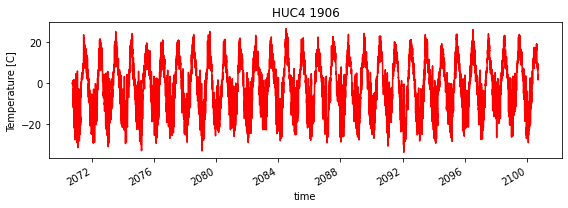

In [10]:
ds = xr.open_dataset(resultpath+domain+'_tair_wy2071-2100.nc')
plotdata = ds.tair.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='r',ax=ax)
ax.set_ylabel('Temperature [C]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_T_wy2071-2100.png',dpi=300)

# Annual summary

In [9]:
df1 = pd.read_csv(resultpath+'temp/'+domain+'_annual_disc_coast_wy2071-2100.csv',index_col=0)
df2 = pd.read_csv(resultpath+'temp/'+domain+'_annual_etx_wy2071-2100.csv')
df2 = df2.drop(columns=['Unnamed: 0','water_year'])
df3 = pd.read_csv(resultpath+'temp/'+domain+'_annual_prec_wy2071-2100.csv')
df3 = df3.drop(columns=['Unnamed: 0','water_year'])
df4 = pd.read_csv(resultpath+'temp/'+domain+'_annual_ssub_wy2071-2100.csv')
df4 = df4.drop(columns=['Unnamed: 0','water_year'])
df5 = pd.read_csv(resultpath+'temp/'+domain+'_annual_swed_wy2071-2100.csv')
df5 = df5.drop(columns=['Unnamed: 0','water_year','endofwy_swed_m3'])
df6 = pd.read_csv(resultpath+'temp/'+domain+'_annual_tair_wy2071-2100.csv')
df6 = df6.drop(columns=['Unnamed: 0','water_year'])

In [10]:
dffinal = pd.concat([df1, df2,df3,df4,df5,df6], axis=1)
#df['water_bal_frac'] = (df.annual_prec_cmd - (df.annual_Qcoast_cmd+df.annual_etx_cmd+df.annual_ssub_cmd))/df.annual_prec_cmd
dffinal

,water_year,annual_Qcoast_m3,annual_etx_m3,annual_prec_m3,annual_ssub_m3,annual_max_swed_m3,annual_av_tair_C
0,2071,7.947435e+10,2.730064e+10,1.135286e+11,5.485822e+09,2.888259e+10,-3.645844
1,2072,7.405607e+10,2.516004e+10,1.138491e+11,6.550951e+09,2.492875e+10,-4.133217
2,2073,1.005716e+11,3.105646e+10,1.547102e+11,7.977665e+09,2.579521e+10,-1.886424
3,2074,1.109549e+11,3.325036e+10,1.611374e+11,7.791242e+09,2.824768e+10,-2.308656
4,2075,1.126364e+11,4.029953e+10,1.666932e+11,6.166336e+09,3.499886e+10,-2.464716
5,2076,1.006384e+11,3.596565e+10,1.533433e+11,7.722898e+09,2.643736e+10,-2.715422
6,2077,8.279723e+10,3.003833e+10,1.286435e+11,4.956284e+09,2.639394e+10,-2.462833
7,2078,9.563600e+10,3.374930e+10,1.479200e+11,5.099082e+09,2.381303e+10,-1.499999
8,2079,8.133936e+10,2.662880e+10,1.200643e+11,5.158696e+09,2.448273e+10,-2.648449
9,2080,9.074450e+10,3.223936e+10,1.380157e+11,6.683607e+09,3.604750e+10,-3.988201


In [11]:
dffinal.to_csv(resultpath+domain+'_annual_summary_wy2071-2100.csv',float_format='%.2f')

# monthly climatology

In [3]:
ds = xr.open_dataset(resultpath+domain+'_disc_coast_wy2071-2100.nc')
group = ds.disc_coast.sum(dim=['id'])
groupm = group.groupby('time.month').mean()
df = pd.DataFrame({'month':groupm.month.values,'disc_coast_m3':[round(val,2) for val in groupm.values]})
ds = xr.open_dataset(resultpath+domain+'_etx_wy2071-2100.nc')
group = ds.et.sum(dim=['x','y'])
groupm = group.groupby('time.month').mean()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['et_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_prec_wy2071-2100.nc')
group = ds.prec.sum(dim=['x','y'])
groupm = group.groupby('time.month').mean()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['prec_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_ssub_wy2071-2100.nc')
group = ds.sub.sum(dim=['x','y'])
groupm = group.groupby('time.month').mean()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['sub_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_swed_wy2071-2100.nc')
group = ds.swed.sum(dim=['x','y'])
groupm = group.groupby('time.month').max()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['swe_max_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_tair_wy2071-2100.nc')
group = ds.tair.mean(dim=['x','y'])
groupm = group.groupby('time.month').mean()
df['tair_av_C']=[round(val,2) for val in groupm.values]
df.to_csv(resultpath+domain+'_monthly_climatology_wy2071-2100.csv')